ЗАПУСК АНАЛИЗА TITANIC DATASET
МЕТОД ВЕСОВ ПРИЗНАКОВ: MULTIPLICATION
РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ
АНАЛИЗ ВЫЖИВАЕМОСТИ НА TITANIC


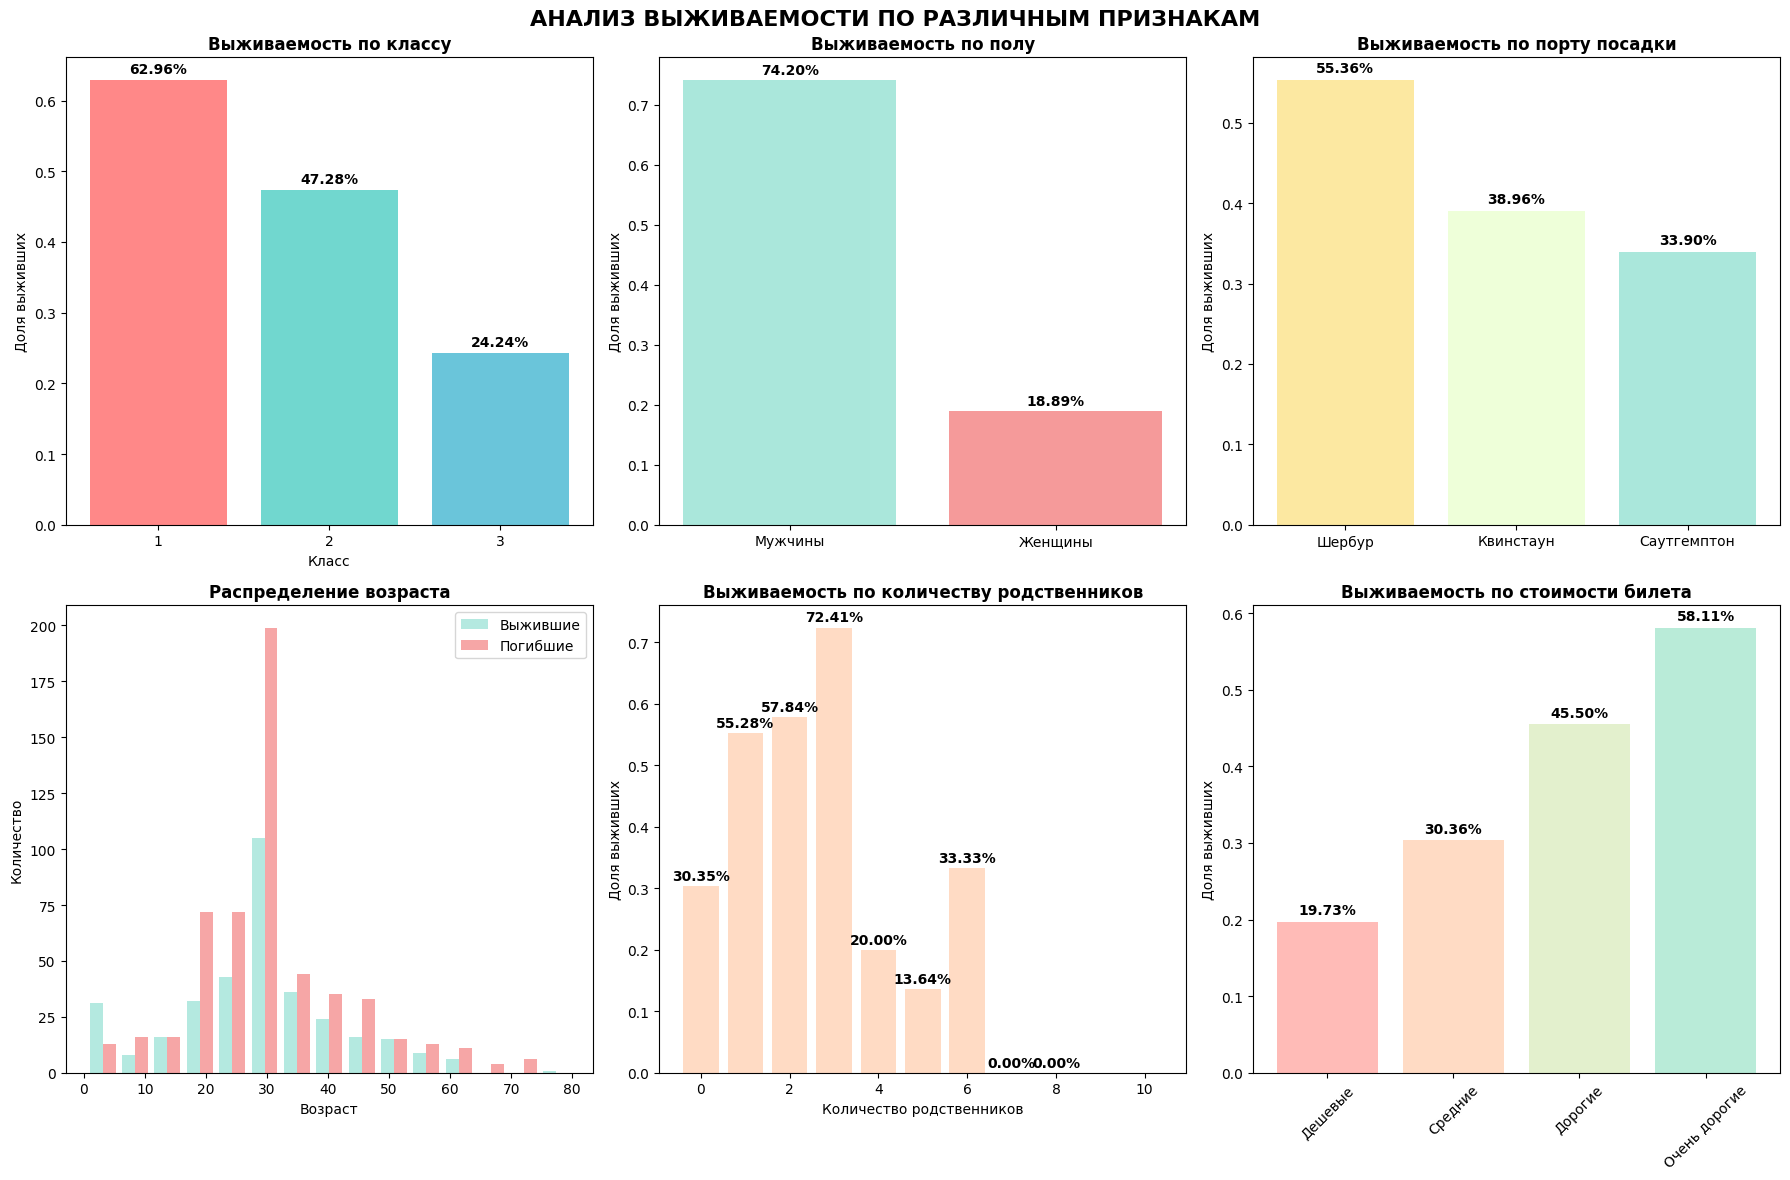

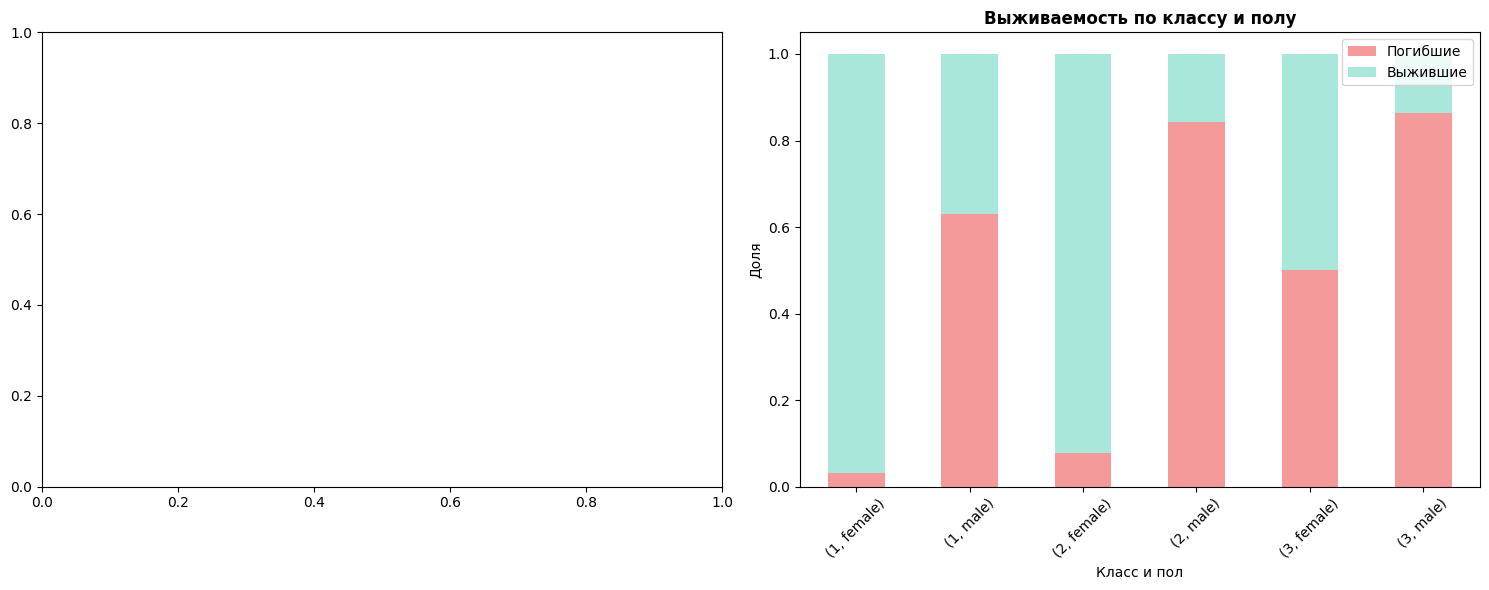


СТАТИСТИКА ВЫЖИВАЕМОСТИ:
Общее количество пассажиров: 891
Выживших: 342 (38.38%)
Погибших: 549 (61.62%)

ВЫЖИВАЕМОСТЬ ПО КЛАССАМ:
        count  sum    mean
Pclass                    
1         216  136  62.96%
2         184   87  47.28%
3         491  119  24.24%

ВЫЖИВАЕМОСТЬ ПО ПОЛУ:
        count  sum    mean
Sex                       
female    314  233  74.20%
male      577  109  18.89%

ВЕСА ПРИЗНАКОВ (на основе ANOVA F-value):
   Sex: 0.5512
   Pclass: 0.1702
   Deck: 0.1312
   Fare: 0.0933
   Embarked: 0.0381
   Parch: 0.0088
   Age: 0.0056
   SibSp: 0.0016
ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...
   Подбор параметров для Random Forest...
      Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'class_weight': None}
      Лучший F1: 0.7727
   Подбор параметров для Logistic Regression...
      Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 1}
      Лучший F1: 0.7383
   Подбор параметров для

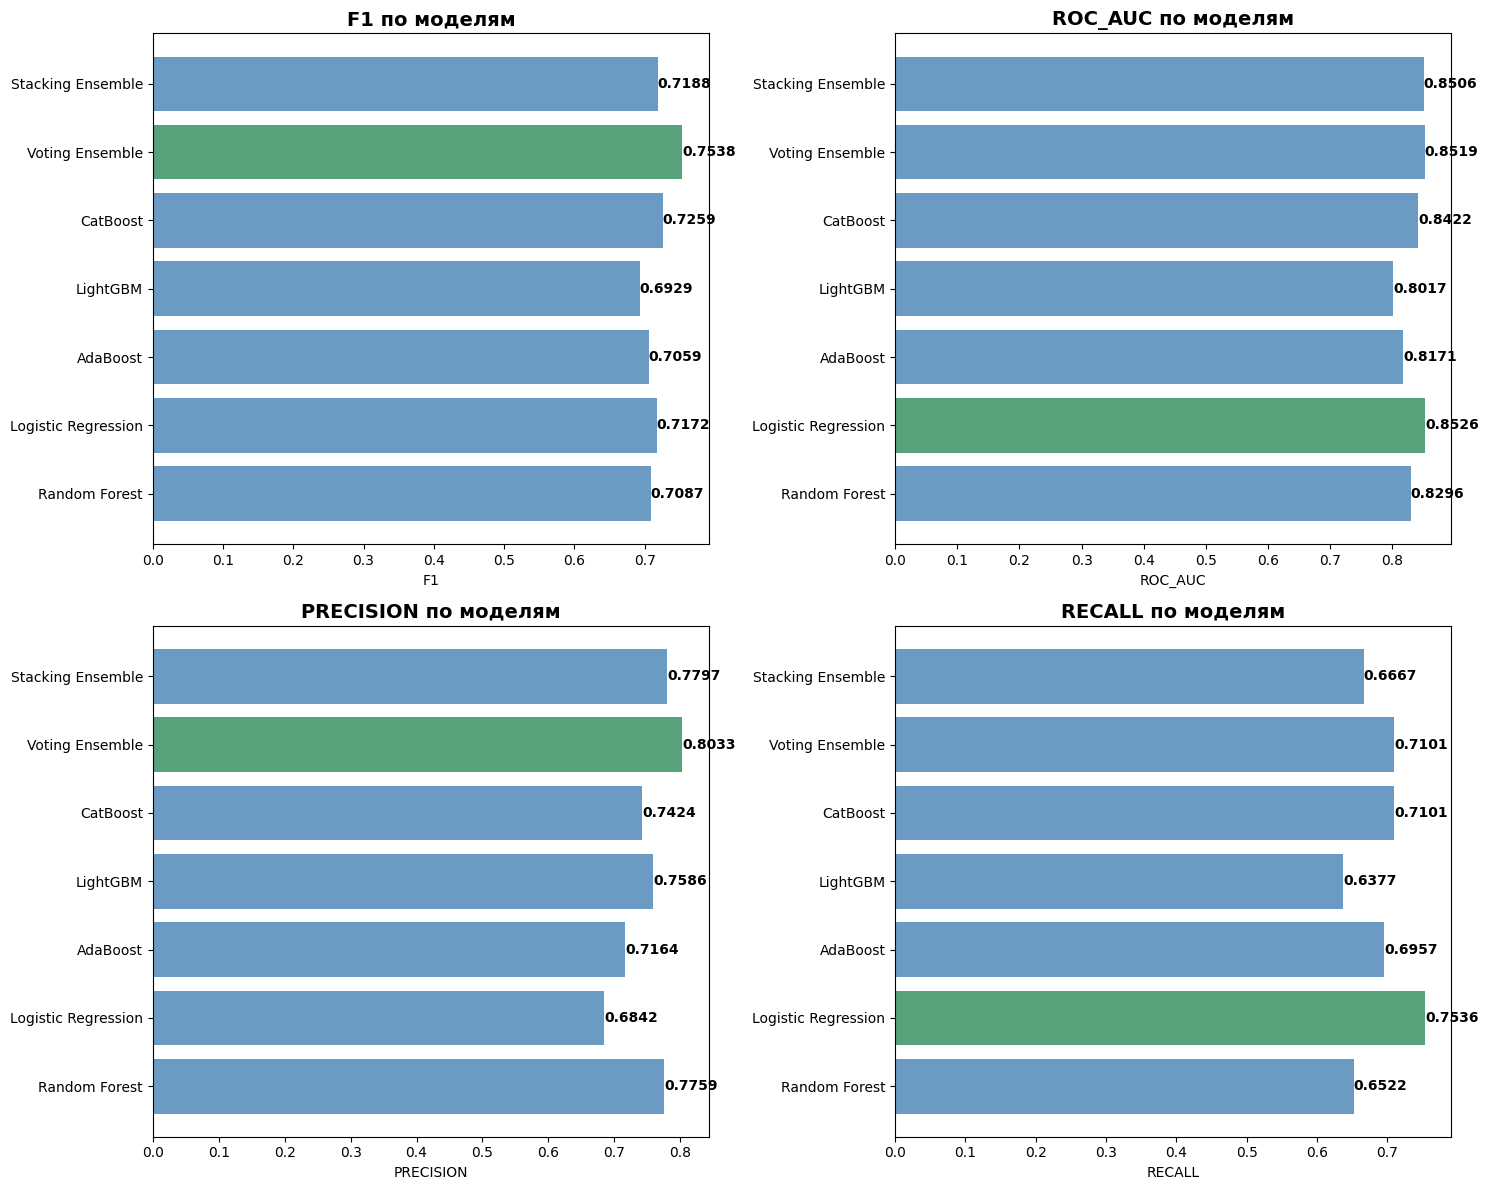

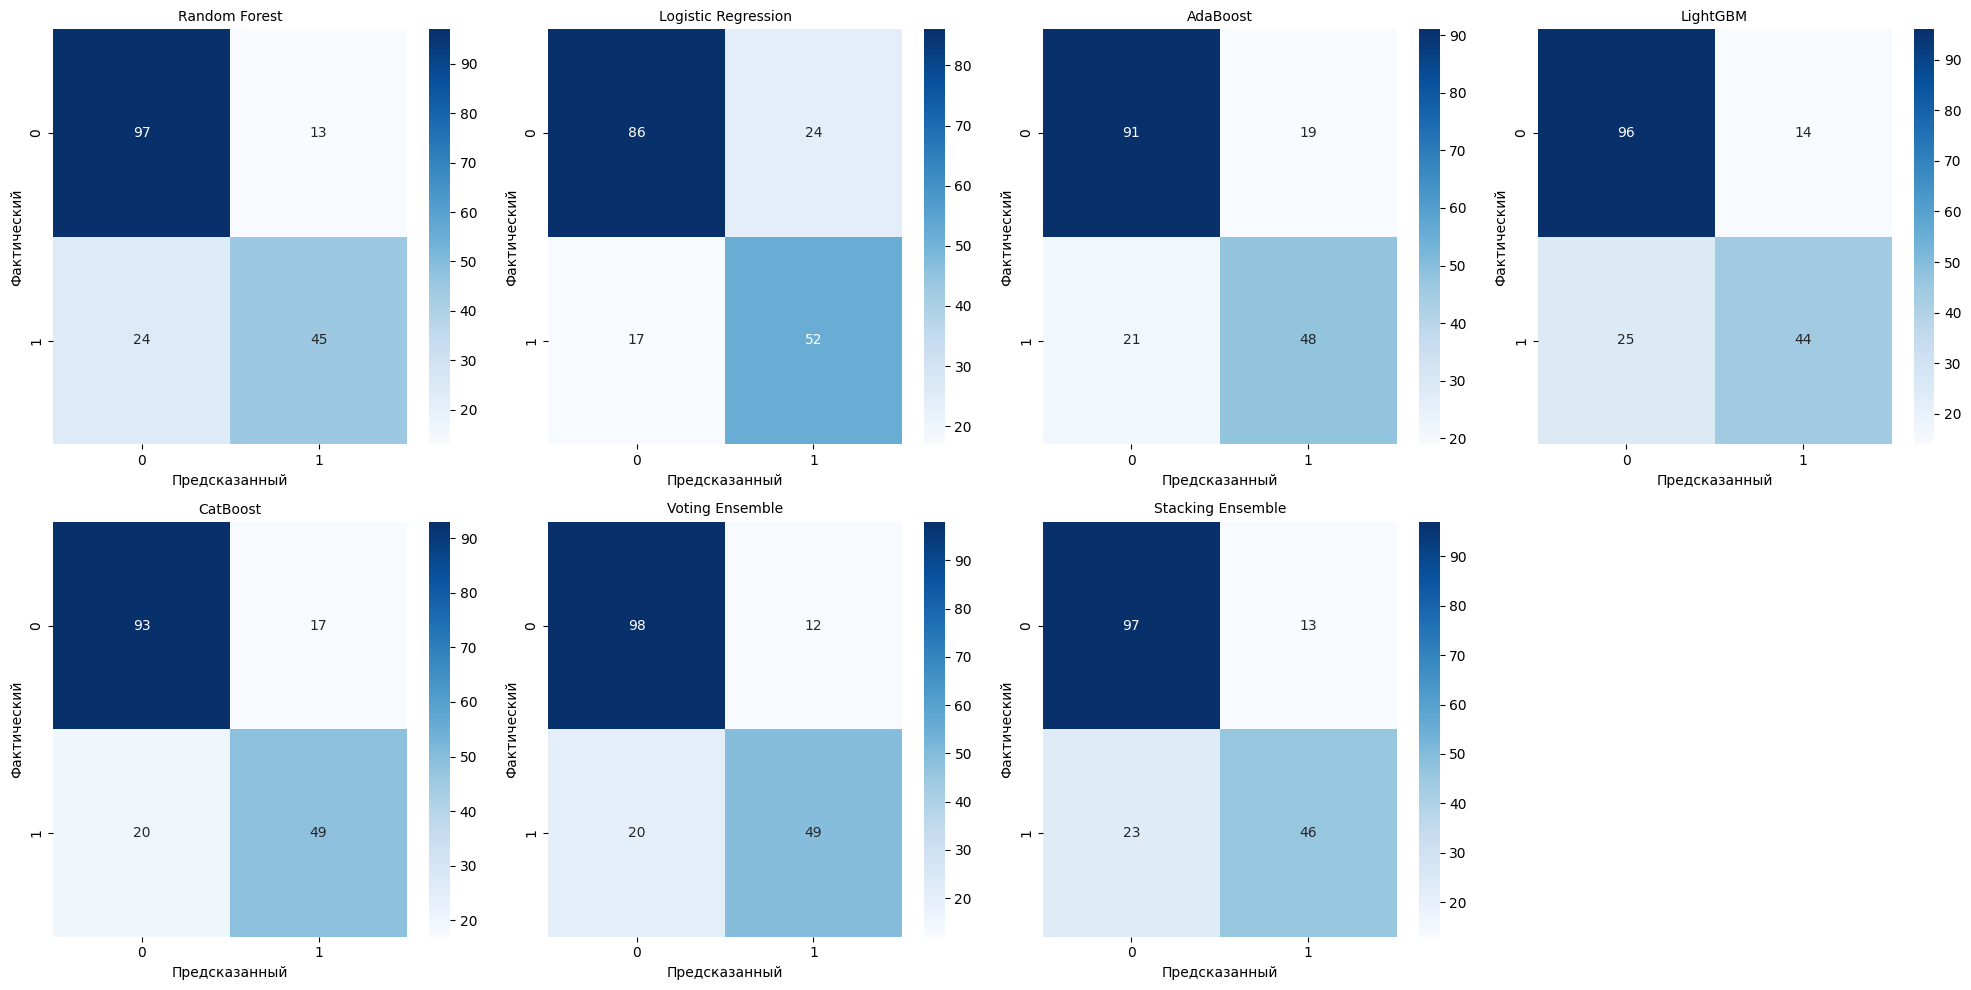


КОМПЛЕКСНЫЙ ОТЧЕТ (MULTIPLICATION)

ИНФОРМАЦИЯ О ДАННЫХ:
   Исходный размер: (891, 12)
   Метод взвешивания: multiplication
   Размер тренировочных данных: (712, 8)
   Баланс классов: {0: 439, 1: 273}

ЛУЧШАЯ МОДЕЛЬ: Voting Ensemble
ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
   Voting Ensemble: Ансамбль (без подбора)

МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:
   F1-Score:       0.7538
   ROC-AUC:        0.8519
   Accuracy:       0.8212
   Precision:      0.8033
   Recall:         0.7101

СРАВНЕНИЕ МОДЕЛЕЙ:
              Model  F1-Score  ROC-AUC  Precision   Recall  Accuracy
    Voting Ensemble  0.753846 0.851910   0.803279 0.710145  0.821229
           CatBoost  0.725926 0.842227   0.742424 0.710145  0.793296
  Stacking Ensemble  0.718750 0.850593   0.779661 0.666667  0.798883
Logistic Regression  0.717241 0.852569   0.684211 0.753623  0.770950
      Random Forest  0.708661 0.829578   0.775862 0.652174  0.793296
           AdaBoost  0.705882 0.817128   0.716418 0.695652  0.776536
           LightGBM  0.692913 0.801713

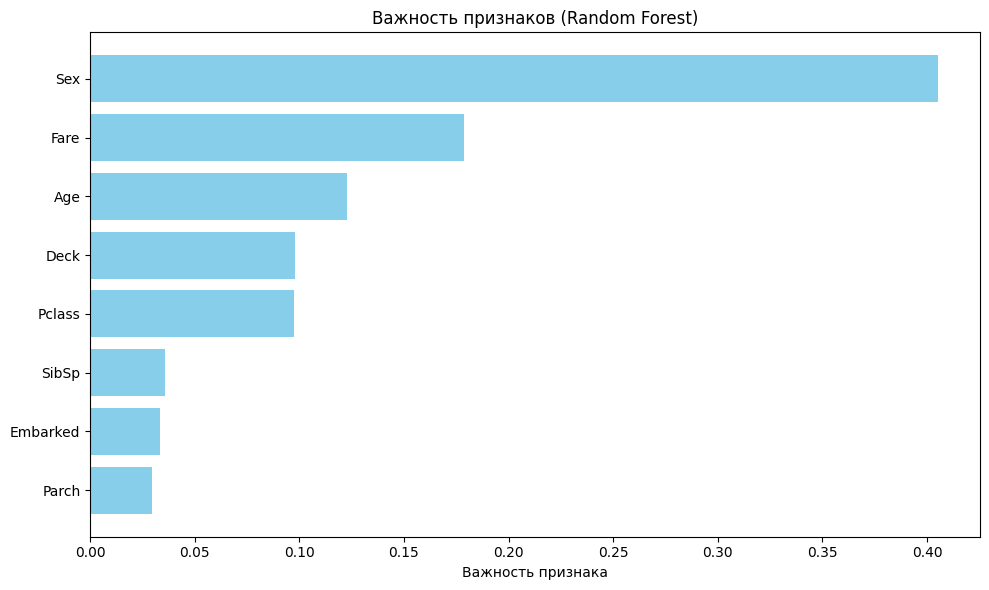

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import catboost as cb


class SmartTitanicPredictor:
    def __init__(self, use_hyperparameter_tuning=True):
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}
        self.feature_names = []
        self.original_shape = None
        self.X_test = None
        self.y_test = None
        self.use_hyperparameter_tuning = use_hyperparameter_tuning
        self.best_params = {}
        self.feature_weights = None
        
    def load_and_preprocess_data(self, file_path):
        # Загрузка и предварительная обработка данных
        data = pd.read_csv(file_path)
        self.original_shape = data.shape
        
        df = data.copy()
        
        # Обработка пропущенных значений
        df['Age'].fillna(df['Age'].median(), inplace=True)
        df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
        df['Fare'].fillna(df['Fare'].median(), inplace=True)
        df['Cabin'].fillna('Unknown', inplace=True)
        
        # Упрощенная обработка каюты
        df['Deck'] = df['Cabin'].str[0]
        
        # Кодирование категориальных переменных
        label_encoders = {}
        categorical_cols = ['Sex', 'Embarked', 'Deck']
        
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
        
        # Базовые признаки (убраны созданные ранее)
        features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck']
        
        X = df[features]
        y = df['Survived']
        
        self.feature_names = features
        return X, y, df

    def exploratory_data_analysis(self, data):
        """Анализ выживаемости по различным признакам"""
        print("АНАЛИЗ ВЫЖИВАЕМОСТИ НА TITANIC")
        print("=" * 50)
        
        # Создаем копию данных для анализа
        df_analysis = data.copy()
        
        # Заполняем пропуски для визуализации
        df_analysis['Age'].fillna(df_analysis['Age'].median(), inplace=True)
        df_analysis['Embarked'].fillna(df_analysis['Embarked'].mode()[0], inplace=True)
        
        # Создаем фигуру с несколькими subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('АНАЛИЗ ВЫЖИВАЕМОСТИ ПО РАЗЛИЧНЫМ ПРИЗНАКАМ', fontsize=16, fontweight='bold')
        
        # 1. Выживаемость по классу
        survival_by_class = df_analysis.groupby('Pclass')['Survived'].mean()
        axes[0, 0].bar(survival_by_class.index, survival_by_class.values, 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
        axes[0, 0].set_title('Выживаемость по классу', fontweight='bold')
        axes[0, 0].set_xlabel('Класс')
        axes[0, 0].set_ylabel('Доля выживших')
        axes[0, 0].set_xticks([1, 2, 3])
        for i, v in enumerate(survival_by_class.values):
            axes[0, 0].text(i+1, v + 0.01, f'{v:.2%}', ha='center', fontweight='bold')
        
        # 2. Выживаемость по полу
        survival_by_sex = df_analysis.groupby('Sex')['Survived'].mean()
        axes[0, 1].bar(['Мужчины', 'Женщины'], survival_by_sex.values, 
                      color=['#95E1D3', '#F38181'], alpha=0.8)
        axes[0, 1].set_title('Выживаемость по полу', fontweight='bold')
        axes[0, 1].set_ylabel('Доля выживших')
        for i, v in enumerate(survival_by_sex.values):
            axes[0, 1].text(i, v + 0.01, f'{v:.2%}', ha='center', fontweight='bold')
        
        # 3. Выживаемость по порту посадки
        survival_by_embarked = df_analysis.groupby('Embarked')['Survived'].mean()
        ports = {'C': 'Шербур', 'Q': 'Квинстаун', 'S': 'Саутгемптон'}
        port_names = [ports.get(x, x) for x in survival_by_embarked.index]
        axes[0, 2].bar(port_names, survival_by_embarked.values, 
                      color=['#FCE38A', '#EAFFD0', '#95E1D3'], alpha=0.8)
        axes[0, 2].set_title('Выживаемость по порту посадки', fontweight='bold')
        axes[0, 2].set_ylabel('Доля выживших')
        for i, v in enumerate(survival_by_embarked.values):
            axes[0, 2].text(i, v + 0.01, f'{v:.2%}', ha='center', fontweight='bold')
        
        # 4. Распределение возраста выживших и погибших
        survived_age = df_analysis[df_analysis['Survived'] == 1]['Age']
        not_survived_age = df_analysis[df_analysis['Survived'] == 0]['Age']
        
        axes[1, 0].hist([survived_age, not_survived_age], 
                       bins=15, alpha=0.7, color=['#95E1D3', '#F38181'], 
                       label=['Выжившие', 'Погибшие'])
        axes[1, 0].set_title('Распределение возраста', fontweight='bold')
        axes[1, 0].set_xlabel('Возраст')
        axes[1, 0].set_ylabel('Количество')
        axes[1, 0].legend()
        
        # 5. Выживаемость по количеству родственников
        df_analysis['Relatives'] = df_analysis['SibSp'] + df_analysis['Parch']
        survival_by_relatives = df_analysis.groupby('Relatives')['Survived'].mean()
        axes[1, 1].bar(survival_by_relatives.index, survival_by_relatives.values, 
                      color='#FFD3B6', alpha=0.8)
        axes[1, 1].set_title('Выживаемость по количеству родственников', fontweight='bold')
        axes[1, 1].set_xlabel('Количество родственников')
        axes[1, 1].set_ylabel('Доля выживших')
        for i, v in enumerate(survival_by_relatives.values):
            axes[1, 1].text(i, v + 0.01, f'{v:.2%}', ha='center', fontweight='bold')
        
        # 6. Выживаемость по стоимости билета (группы)
        df_analysis['FareGroup'] = pd.qcut(df_analysis['Fare'], 4, 
                                         labels=['Дешевые', 'Средние', 'Дорогие', 'Очень дорогие'])
        survival_by_fare = df_analysis.groupby('FareGroup')['Survived'].mean()
        axes[1, 2].bar(survival_by_fare.index, survival_by_fare.values, 
                      color=['#FFAAA5', '#FFD3B6', '#DCEDC1', '#A8E6CF'], alpha=0.8)
        axes[1, 2].set_title('Выживаемость по стоимости билета', fontweight='bold')
        axes[1, 2].set_ylabel('Доля выживших')
        axes[1, 2].tick_params(axis='x', rotation=45)
        for i, v in enumerate(survival_by_fare.values):
            axes[1, 2].text(i, v + 0.01, f'{v:.2%}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Дополнительные графики
        self._create_additional_plots(df_analysis)
        
        # Статистика выживаемости
        self._print_survival_statistics(df_analysis)
    
    def _create_additional_plots(self, df):
        """Создание дополнительных графиков анализа"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        
        
        # 2. Выживаемость по полу и классу
        cross_tab = pd.crosstab([df['Pclass'], df['Sex']], df['Survived'], normalize='index')
        cross_tab.plot(kind='bar', stacked=True, color=['#F38181', '#95E1D3'], 
                      ax=axes[1], alpha=0.8)
        axes[1].set_title('Выживаемость по классу и полу', fontweight='bold')
        axes[1].set_xlabel('Класс и пол')
        axes[1].set_ylabel('Доля')
        axes[1].legend(['Погибшие', 'Выжившие'])
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def _print_survival_statistics(self, df):
        """Вывод статистики выживаемости"""
        total_passengers = len(df)
        total_survived = df['Survived'].sum()
        survival_rate = total_survived / total_passengers
        
        print("\nСТАТИСТИКА ВЫЖИВАЕМОСТИ:")
        print("=" * 40)
        print(f"Общее количество пассажиров: {total_passengers}")
        print(f"Выживших: {total_survived} ({survival_rate:.2%})")
        print(f"Погибших: {total_passengers - total_survived} ({(1-survival_rate):.2%})")
        
        # Статистика по классам
        print("\nВЫЖИВАЕМОСТЬ ПО КЛАССАМ:")
        class_stats = df.groupby('Pclass')['Survived'].agg(['count', 'sum', 'mean'])
        class_stats['mean'] = class_stats['mean'].apply(lambda x: f"{x:.2%}")
        print(class_stats)
        
        # Статистика по полу
        print("\nВЫЖИВАЕМОСТЬ ПО ПОЛУ:")
        sex_stats = df.groupby('Sex')['Survived'].agg(['count', 'sum', 'mean'])
        sex_stats['mean'] = sex_stats['mean'].apply(lambda x: f"{x:.2%}")
        print(sex_stats)
        
    def calculate_feature_weights(self, X, y):
        """Вычисление весов признаков на основе их важности"""
        # Используем ANOVA F-value для числовых признаков
        selector = SelectKBest(score_func=f_classif, k='all')
        selector.fit(X, y)
        
        # Нормализуем веса
        weights = selector.scores_ / np.sum(selector.scores_)
        self.feature_weights = dict(zip(self.feature_names, weights))
        
        print("\nВЕСА ПРИЗНАКОВ (на основе ANOVA F-value):")
        for feature, weight in sorted(self.feature_weights.items(), key=lambda x: x[1], reverse=True):
            print(f"   {feature}: {weight:.4f}")
        
        return self.feature_weights
    
    def apply_feature_weights(self, X, method='multiplication'):
        """Применение весов признаков к данным"""
        if self.feature_weights is None:
            return X
        
        X_weighted = X.copy()
        
        if method == 'multiplication':
            # Умножение признаков на их веса
            for feature, weight in self.feature_weights.items():
                if feature in X.columns:
                    X_weighted[feature] = X[feature] * weight
        elif method == 'selection':
            # Отбор наиболее важных признаков
            important_features = [f for f, w in self.feature_weights.items() if w > np.median(list(self.feature_weights.values()))]
            X_weighted = X[important_features]
            print(f"Отобрано {len(important_features)} наиболее важных признаков: {important_features}")
        
        return X_weighted
    
    def create_optimized_models(self):
        """Создание моделей с ансамблевыми методами"""
        # Базовые модели
        base_models = {
            'Random Forest': RandomForestClassifier(random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'AdaBoost': AdaBoostClassifier(random_state=42),
            'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
            'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=False)
        }
        
        # Создание ансамблевых моделей
        voting_classifier = VotingClassifier(
            estimators=[
                ('rf', base_models['Random Forest']),
                ('lr', base_models['Logistic Regression']),
                ('lgbm', base_models['LightGBM'])
            ],
            voting='soft'
        )
        
        stacking_classifier = StackingClassifier(
            estimators=[
                ('rf', base_models['Random Forest']),
                ('lgbm', base_models['LightGBM']),
                ('catboost', base_models['CatBoost'])
            ],
            final_estimator=LogisticRegression(random_state=42, max_iter=1000),
            cv=5
        )
        
        self.models = {
            **base_models,
            'Voting Ensemble': voting_classifier,
            'Stacking Ensemble': stacking_classifier
        }
    
    def hyperparameter_tuning(self, X_train, y_train):
        """Подбор гиперпараметров с учетом весов признаков"""
        print("ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...")
        
        param_grids = {
            'Random Forest': {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, 15, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'class_weight': ['balanced', None]
            },
            'Logistic Regression': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'solver': ['liblinear', 'lbfgs'],
                'penalty': ['l1', 'l2'],
                'class_weight': ['balanced', None]
            },
            'AdaBoost': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.5, 1]
            },
            'LightGBM': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7, -1],
                'num_leaves': [31, 50, 100],
                'is_unbalance': [True, False]
            },
            'CatBoost': {
                'iterations': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1],
                'depth': [4, 6, 8],
                'auto_class_weights': ['Balanced', 'None']
            }
        }
        
        tuned_models = {}
        
        for name, model in self.models.items():
            # Пропускаем ансамблевые модели для подбора параметров
            if 'Ensemble' in name:
                tuned_models[name] = model
                self.best_params[name] = "Ансамбль (без подбора)"
                print(f"   {name}: используется как ансамбль")
                continue
                
            print(f"   Подбор параметров для {name}...")
            
            try:
                if name in param_grids:
                    search = RandomizedSearchCV(
                        model, 
                        param_grids[name], 
                        n_iter=15,
                        cv=3,
                        scoring='f1',
                        n_jobs=-1,
                        random_state=42,
                        verbose=0
                    )
                    
                    search.fit(X_train, y_train)
                    
                    tuned_models[name] = search.best_estimator_
                    self.best_params[name] = search.best_params_
                    
                    print(f"      Лучшие параметры: {search.best_params_}")
                    print(f"      Лучший F1: {search.best_score_:.4f}")
                else:
                    tuned_models[name] = model
                    self.best_params[name] = "По умолчанию"
                    print(f"      Используются параметры по умолчанию")
                    
            except Exception as e:
                print(f"      Ошибка при подборе параметров для {name}: {e}")
                tuned_models[name] = model
                self.best_params[name] = "По умолчанию (ошибка)"
        
        return tuned_models
    
    def optimize_and_train(self, X_train, X_test, y_train, y_test):
        """Обучение и оптимизация моделей с учетом весов признаков"""
        if self.use_hyperparameter_tuning:
            tuned_models = self.hyperparameter_tuning(X_train, y_train)
        else:
            tuned_models = self.models
            for name in tuned_models.keys():
                if 'Ensemble' in name:
                    self.best_params[name] = "Ансамбль"
                else:
                    self.best_params[name] = "Без подбора"
        
        print("\nОБУЧЕНИЕ МОДЕЛЕЙ...")
        
        for name, model in tuned_models.items():
            print(f"Обучение {name}...")
            
            try:
                model.fit(X_train, y_train)
                
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                
                f1 = f1_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                accuracy = model.score(X_test, y_test)
                
                cm = confusion_matrix(y_test, y_pred)
                tn, fp, fn, tp = cm.ravel()
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                
                feature_importance = None
                if hasattr(model, 'feature_importances_'):
                    feature_importance = model.feature_importances_
                elif hasattr(model, 'coef_'):
                    feature_importance = np.abs(model.coef_[0])
                
                self.results[name] = {
                    'f1': f1,
                    'roc_auc': roc_auc,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'feature_importance': feature_importance,
                    'model': model
                }
                
                print(f"   F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
                
            except Exception as e:
                print(f"   Ошибка при обучении {name}: {e}")
    
    def run_complete_analysis(self, file_path, weighting_method='multiplication'):
        """Запуск полного анализа с использованием весов признаков"""
        print(f"ЗАПУСК АНАЛИЗА TITANIC DATASET")
        print(f"МЕТОД ВЕСОВ ПРИЗНАКОВ: {weighting_method.upper()}")
        if self.use_hyperparameter_tuning:
            print("РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ")
        else:
            print("РЕЖИМ: БЕЗ ПОДБОРА ГИПЕРПАРАМЕТРОВ")
        print("=" * 60)
        
        # Загрузка данных для анализа
        data = pd.read_csv(file_path)
        
        # Проведение анализа выживаемости
        self.exploratory_data_analysis(data)
        
        # Предобработка данных для моделирования
        X, y, processed_df = self.load_and_preprocess_data(file_path)
        
        # Вычисление весов признаков
        self.calculate_feature_weights(X, y)
        
        # Применение весов к данным
        X_weighted = self.apply_feature_weights(X, method=weighting_method)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_weighted, y, test_size=0.2, random_state=42, stratify=y
        )
        
        self.X_test = X_test
        self.y_test = y_test
        
        # Масштабирование данных
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.create_optimized_models()
        self.optimize_and_train(X_train_scaled, X_test_scaled, y_train, y_test)
        
        self.visualize_results()
        self.generate_comprehensive_report(X_train, y_train, weighting_method)
        
        return self.results
    
    def compare_weighting_methods(self, file_path):
        """Сравнение различных методов взвешивания признаков"""
        methods = ['multiplication', 'selection', 'none']
        comparison_data = []
        
        print("СРАВНЕНИЕ МЕТОДОВ ВЗВЕШИВАНИЯ ПРИЗНАКОВ")
        if self.use_hyperparameter_tuning:
            print("РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ")
        print("=" * 60)
        
        for method in methods:
            print(f"\nТестирование метода: {method.upper()}")
            print("-" * 40)
            
            # Сброс результатов для каждого метода
            self.results = {}
            
            X, y, processed_df = self.load_and_preprocess_data(file_path)
            self.calculate_feature_weights(X, y)
            
            if method == 'none':
                X_weighted = X
            else:
                X_weighted = self.apply_feature_weights(X, method=method)
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_weighted, y, test_size=0.2, random_state=42, stratify=y
            )
            
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)
            
            self.create_optimized_models()
            self.optimize_and_train(X_train_scaled, X_test_scaled, y_train, y_test)
            
            if self.results:
                best_model_name = max(self.results.items(), key=lambda x: x[1]['f1'] + x[1]['roc_auc'])[0]
                best_result = self.results[best_model_name]
                
                comparison_data.append({
                    'Method': method.upper(),
                    'Best Model': best_model_name,
                    'F1-Score': best_result['f1'],
                    'ROC-AUC': best_result['roc_auc'],
                    'Accuracy': best_result['accuracy'],
                    'Precision': best_result['precision'],
                    'Recall': best_result['recall']
                })
        
        self.visualize_weighting_comparison(comparison_data)
        
        return comparison_data
    
    def visualize_weighting_comparison(self, comparison_data):
        """Визуализация сравнения методов взвешивания"""
        if not comparison_data:
            return
            
        df_comparison = pd.DataFrame(comparison_data)
        
        metrics = ['F1-Score', 'ROC-AUC', 'Accuracy', 'Precision', 'Recall']
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.ravel()
        
        for i, metric in enumerate(metrics):
            if i < len(axes):
                bars = axes[i].barh(df_comparison['Method'], df_comparison[metric], 
                                  color=['#2E8B57', '#4682B4', '#FF6347'])
                axes[i].set_title(f'{metric} по методам взвешивания', fontsize=12, fontweight='bold')
                axes[i].set_xlabel(metric)
                
                for bar, value in zip(bars, df_comparison[metric]):
                    axes[i].text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                               f'{value:.4f}', ha='left', va='center', fontweight='bold')
        
        if len(metrics) < len(axes):
            for i in range(len(metrics), len(axes)):
                axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "=" * 80)
        print("СРАВНЕНИЕ МЕТОДОВ ВЗВЕШИВАНИЯ ПРИЗНАКОВ")
        print("=" * 80)
        print(df_comparison.to_string(index=False))
        
        best_method = df_comparison.loc[df_comparison['F1-Score'].idxmax()]
        print(f"\nЛУЧШИЙ МЕТОД ВЗВЕШИВАНИЯ: {best_method['Method']}")
        print(f"   F1-Score: {best_method['F1-Score']:.4f}")
        print(f"   ROC-AUC: {best_method['ROC-AUC']:.4f}")
        print(f"   Лучшая модель: {best_method['Best Model']}")
    
    def visualize_results(self):
        """Визуализация результатов"""
        if not self.results:
            return
            
        models = list(self.results.keys())
        metrics = ['f1', 'roc_auc', 'precision', 'recall']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
        
        for i, metric in enumerate(metrics):
            values = [self.results[model][metric] for model in models]
            colors = ['#2E8B57' if x == max(values) else '#4682B4' for x in values]
            bars = axes[i].barh(models, values, color=colors, alpha=0.8)
            axes[i].set_title(f'{metric.upper()} по моделям', fontsize=14, fontweight='bold')
            axes[i].set_xlabel(metric.upper())
            
            for bar, value in zip(bars, values):
                axes[i].text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                           f'{value:.4f}', ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Матрицы ошибок
        if self.X_test is not None and self.y_test is not None:
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.ravel()
            
            for idx, (name, result) in enumerate(self.results.items()):
                if idx >= 8:
                    break
                model = result['model']
                X_test_scaled = self.scaler.transform(self.X_test)
                y_pred = model.predict(X_test_scaled)
                cm = confusion_matrix(self.y_test, y_pred)
                
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
                axes[idx].set_title(f'{name}', fontsize=10)
                axes[idx].set_xlabel('Предсказанный')
                axes[idx].set_ylabel('Фактический')
            
            for idx in range(len(self.results), 8):
                axes[idx].set_visible(False)
            
            plt.tight_layout()
            plt.show()
    
    def generate_comprehensive_report(self, X_train, y_train, weighting_method):
        """Генерация комплексного отчета"""
        if not self.results:
            return
            
        best_model_name = max(self.results.items(), 
                            key=lambda x: x[1]['f1'] + x[1]['roc_auc'])[0]
        best_result = self.results[best_model_name]
        
        print("\n" + "=" * 80)
        print(f"КОМПЛЕКСНЫЙ ОТЧЕТ ({weighting_method.upper()})")
        print("=" * 80)
        
        print(f"\nИНФОРМАЦИЯ О ДАННЫХ:")
        print(f"   Исходный размер: {self.original_shape}")
        print(f"   Метод взвешивания: {weighting_method}")
        print(f"   Размер тренировочных данных: {X_train.shape}")
        print(f"   Баланс классов: {pd.Series(y_train).value_counts().to_dict()}")
        
        print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
        print("=" * 50)
        
        print(f"ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:")
        for model_name, params in self.best_params.items():
            if model_name == best_model_name:
                print(f"   {model_name}: {params}")
        
        print(f"\nМЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:")
        print(f"   F1-Score:       {best_result['f1']:.4f}")
        print(f"   ROC-AUC:        {best_result['roc_auc']:.4f}")
        print(f"   Accuracy:       {best_result['accuracy']:.4f}")
        print(f"   Precision:      {best_result['precision']:.4f}")
        print(f"   Recall:         {best_result['recall']:.4f}")
        
        print(f"\nСРАВНЕНИЕ МОДЕЛЕЙ:")
        comparison_df = pd.DataFrame({
            'Model': list(self.results.keys()),
            'F1-Score': [self.results[m]['f1'] for m in self.results],
            'ROC-AUC': [self.results[m]['roc_auc'] for m in self.results],
            'Precision': [self.results[m]['precision'] for m in self.results],
            'Recall': [self.results[m]['recall'] for m in self.results],
            'Accuracy': [self.results[m]['accuracy'] for m in self.results]
        }).sort_values('F1-Score', ascending=False)
        
        print(comparison_df.to_string(index=False))
        
        # Важность признаков
        models_with_importance = [name for name in self.results 
                                if self.results[name]['feature_importance'] is not None]
        
        if models_with_importance:
            best_model_with_importance = models_with_importance[0]
            best_importance = self.results[best_model_with_importance]['feature_importance']
            
            print(f"\nВАЖНОСТЬ ПРИЗНАКОВ ({best_model_with_importance}):")
            feature_imp = pd.DataFrame({
                'Признак': self.feature_names[:len(best_importance)],
                'Важность': best_importance
            }).sort_values('Важность', ascending=False)
            
            for _, row in feature_imp.iterrows():
                importance_pct = (row['Важность'] / feature_imp['Важность'].sum()) * 100
                print(f"   {row['Признак']}: {importance_pct:.1f}%")
            
            plt.figure(figsize=(10, 6))
            feature_imp_plot = feature_imp.sort_values('Важность', ascending=True)
            plt.barh(feature_imp_plot['Признак'], feature_imp_plot['Важность'], color='skyblue')
            plt.xlabel('Важность признака')
            plt.title(f'Важность признаков ({best_model_with_importance})')
            plt.tight_layout()
            plt.show()


# Запуск анализа
if __name__ == "__main__":
    predictor = SmartTitanicPredictor(use_hyperparameter_tuning=True)
    
    # Запуск с одним методом взвешивания
    predictor.run_complete_analysis('Titanic-Dataset.csv', weighting_method='multiplication')
    
    # Сравнение всех методов взвешивания
    # comparison_results = predictor.compare_weighting_methods('Titanic-Dataset.csv')